In [1]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pygrib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

In [2]:
# starting and ending viewazimuths
azim_start = 270
azim_end = 200

# starting and ending view elevations
elev_start = 50
elev_end = 40

# starting and ending zooms
dist_start = 300
dist_end = 400

# starting and ending center latitude
lat_start = 43
lat_end = 38

# starting and ending longitude
lon_start = -97
lon_end = -93

# starting and ending layer separation
delev_start = 0
delev_end = 5

# delta center degrees
# latitude window for center
# tradoff with dist
ddeg = 1

#save files setup
savepath = '../plots/map/movie/animate_test/'
filename = 'test'


num_steps = 100

for i in range(num_steps):
    delev = delev_start-i*((delev_start-delev_end)/num_steps)
    hour = str(i-24*(i//24)).zfill(2)
    day = str(1+i//24).zfill(2)
    try:
        grbs = pygrib.open(f'../data/weather/august_full/rap_130_201808{day}_{hour}00_000.grb2')
    except:
        continue
    variables = ['Wind speed (gust)','Visibility','Total Cloud Cover']
    datas = []
    colors = ['viridis','magma','viridis']
    elev = np.arange(len(variables))*delev

    for variable in variables:
        grb = grbs.select(name=variable)[0]
        lats, lons = grb.latlons()
        datas.append(grb['values'])

    map = Basemap(llcrnrlon=-360,llcrnrlat=-90,urcrnrlon=360,urcrnrlat=90,)

    fig = plt.figure(figsize=[10,10])
    ax = Axes3D(fig)

    ax.add_collection3d(map.drawcoastlines(linewidth=0.25))
    ax.add_collection3d(map.drawcountries(linewidth=0.35))

    polys = []
    for polygon in map.landpolygons:
        polys.append(polygon.get_coords())


    lc = PolyCollection(polys, edgecolor=None,
                        facecolor='#DDDDDD', closed=False)

    #ax.add_collection3d(lc,zs=0)

    ax.set_axis_off()
    ax.azim = azim_start-i*((azim_start-azim_end)/num_steps)
    ax.elev = elev_start-i*((elev_start-elev_end)/num_steps)
    ax.dist = dist_start-i*((dist_start-dist_end)/num_steps)
    
    center_lat = lat_start-i*((lat_start-lat_end)/num_steps)
    center_lon = lon_start-i*((lon_start-lon_end)/num_steps)


    for ix,data in enumerate(datas):
        # fourth dimention - colormap
        # create colormap according to x-value (can use any 50x50 array)
        color_dimension = data # change to desired fourth dimension
        minn, maxx = color_dimension.min(), color_dimension.max()
        norm = matplotlib.colors.Normalize(minn, maxx)
        m = plt.cm.ScalarMappable(norm=norm, cmap=colors[ix])
        m.set_array([])
        fcolors = m.to_rgba(color_dimension)

        ax.plot_surface(lons,lats,np.ones(lats.shape)*elev[ix]+delev/10,cstride=5,rstride=5,facecolors=fcolors, vmin=0, vmax=100, shade=False)

    ax.set_xlim3d(center_lon-ddeg,center_lon+ddeg)
    ax.set_ylim3d(center_lat-ddeg,center_lat+ddeg)
    if i < 10:
        fig.savefig(f'{savepath}{filename}0000{i}.png', dpi=fig.dpi)
    elif i >=10 and i < 100:
        fig.savefig(f'{savepath}{filename}000{i}.png', dpi=fig.dpi)
    elif i >=100 and i < 1000:
        fig.savefig(f'{savepath}{filename}00{i}.png', dpi=fig.dpi)
    elif i > 1000:
        fig.savefig(f'{savepath}{filename}0{i}.png', dpi=fig.dpi)
    plt.close()

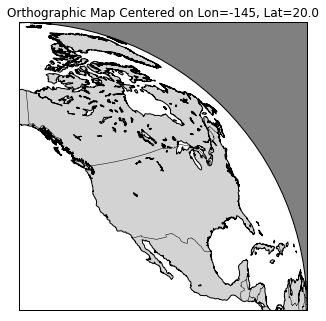

In [2]:
fig = plt.figure()
# global ortho map
lon_0=-145
lat_0=20.
m1 = Basemap(projection='ortho',lon_0=lon_0,lat_0=lat_0,resolution=None)
ax = fig.add_axes([0,0,1,1],facecolor='grey')
# plot just upper right quadrant (corners determined from global map).
m = Basemap(projection='ortho',lon_0=lon_0,lat_0=lat_0,resolution='l',llcrnrx=0.,llcrnry=0.,urcrnrx=m1.urcrnrx/2.,urcrnry=m1.urcrnry/2.)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='lightgrey',lake_color='white')
m.drawcountries()
# draw parallels and meridians.
#m.drawparallels(np.arange(-90.,120.,30.))
#m.drawmeridians(np.arange(0.,420.,60.))
plt.title('Orthographic Map Centered on Lon=%s, Lat=%s' % (lon_0,lat_0))

plt.show()